# Importing required packages

In [93]:
import pandas as pd, numpy as np
import sys, math, pickle, json, csv
import sklearn as skl
from sklearn import *
from collections import defaultdict

In [58]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

matplotlib.rcParams.update({'figure.autolayout': True})

# Import housing typology and vital signs housing dataset

In [59]:
housingTypology = pd.read_csv('../dat/Housing_Market_Typology_2011.csv', thousands=',')

In [60]:
vitalSigns_housing = pd.read_csv('../dat/Vital Signs/VS-Housing-2010-2014.csv', thousands=',')
vitalSigns_housing.drop([55], axis=0, inplace=True)
vitalSigns_housing.sort_values('CSA2010', inplace=True, ascending=True)

In [61]:
vitalSignsRegions = pd.read_csv('../dat/Vital Signs/VitalSignRegionWithArea.csv', thousands=',')
vitalSignsRegions.sort_values('name', inplace=True, ascending=True)

In [62]:
vitalSignsRegions.head()

,name,sqmile
0,Allendale/Irvington/S. Hilton,2.287453
1,Beechfield/Ten Hills/West Hills,1.717551
2,Belair-Edison,1.612362
3,Brooklyn/Curtis Bay/Hawkins Point,6.315926
4,Canton,0.552706


In [63]:
vitalSignsRegions.dtypes

name       object
sqmile    float64
dtype: object

In [64]:
vitalSigns_housing.tail()

,CSA2010,shomes10,shomes11,shomes12,shomes13,shomes14,salepr10,salepr11,salepr12,salepr13,...,baltvac13,vio10,vio11,vio12,vio13,demper11,demper12,demper13,demper14,hcvhouse14
50,Southwest Baltimore,187,153,119,105,152,22500,"$17,000","$21,150","$22,000",...,8.2,7.9,9.8,10.1,11.0,4.4,4.0,1.1,3.0,139.2
51,The Waverlies,74,60,50,69,84,84950,"$56,100","$74,000","$79,200",...,2.7,4.0,4.5,3.2,5.3,0.4,3.7,0.4,1.5,182.9
52,Upton/Druid Heights,61,59,59,43,40,20100,"$30,000","$50,000","$30,000",...,41.7,11.3,12.1,19.1,35.5,2.3,1.4,11.6,2.8,117.9
53,Washington Village/Pigtown,109,86,79,59,151,70000,"$58,450","$92,000","$80,000",...,0.5,2.7,3.0,2.7,3.4,0.0,2.2,2.5,0.0,276.1
54,Westport/Mount Winans/Lakeland,53,33,32,30,62,62250,"$39,000","$52,900","$37,700",...,3.9,3.5,6.5,6.1,6.6,0.5,1.9,1.4,33.6,119.1


In [65]:
for column in ['shomes10', 'shomes11', 'shomes12', 'shomes13', 'shomes14', 
               'totalres10', 'totalres11', 'totalres12', 'totalres13', 'totalres14']:
    vitalSigns_housing[column]=vitalSigns_housing[column].astype(int)

# Remove the dollar symbol from values in the column 'medianSalesPrice20092010' and cast to float datatype
for column in ['salepr10','salepr11','salepr12','salepr13','salepr14']:
    vitalSigns_housing[column]=vitalSigns_housing[column].replace( '[\$,]','', regex=True ).astype(float)
    
    
yearWiseColumnsOfInterest = {
    '2010':['shomes10', 'salepr10','totalres10', 'vacant10'],
    '2011':['shomes11', 'salepr11','totalres11', 'vacant11'],
    '2012':['shomes12', 'salepr12','totalres12', 'vacant12'],
    '2013':['shomes13', 'salepr13','totalres13', 'vacant13'],
    '2014':['shomes14', 'salepr14','totalres14', 'vacant14']
}

In [66]:
decisionTreeModel = pickle.load(open('../models/housing_market_typology_decisionTree.model','rb'))

In [67]:
def assignMarketTypologyForNeighborhoods(year):
    columnsOfInterest=yearWiseColumnsOfInterest[year]
    unitsPerSquareMile = vitalSigns_housing[columnsOfInterest[2]].divide(vitalSignsRegions.sqmile)
    unitsPerSale = unitsPerSquareMile.divide(vitalSigns_housing[columnsOfInterest[0]])
    
    scaler = skl.preprocessing.MinMaxScaler(feature_range=(0,10))
    scaledUnitsPerSale = scaler.fit_transform(unitsPerSale.values.reshape(-1,1))
    scaledUnitsPerSale = pd.DataFrame(scaledUnitsPerSale, index=unitsPerSale.index)
    scaledSalesPrice = scaler.fit_transform(vitalSigns_housing[columnsOfInterest[1]].values.reshape(-1,1))
    scaledSalesPrice = pd.DataFrame(scaledSalesPrice, index=vitalSigns_housing[columnsOfInterest[1]].index)

    scaledVacantHouseNotices = scaler.fit_transform(vitalSigns_housing[columnsOfInterest[3]].values.reshape(-1,1))
    scaledVacantHouseNotices = pd.DataFrame(scaledVacantHouseNotices, 
                                   index=vitalSigns_housing[columnsOfInterest[3]].index)
    
    #X = pd.concat([unitsPerSale, vitalSigns_housing[columnsOfInterest[1]] ], axis=1)
    X = pd.concat([scaledUnitsPerSale, scaledSalesPrice], axis=1)
    X.columns = ['unitsPerSale', 'medianSalesPrice']
#     X = pd.concat([scaledUnitsPerSale, scaledSalesPrice, scaledVacantHouseNotices], axis=1)
#     X.columns = ['unitsPerSale', 'medianSalesPrice', 'vacantHouseNotices']
    X.unitsPerSale.replace(np.inf, np.nan, inplace=True)
    X.unitsPerSale.fillna(value='-1', inplace=True)
    
    predictions = decisionTreeModel.predict(X)
        
    predictions = pd.concat([vitalSigns_housing['CSA2010'], pd.DataFrame(predictions)], axis=1)
    predictions.columns=['CSA2010', 'MarketTypology_'+year]
    predictions['MarketTypology_'+year]=predictions['MarketTypology_'+year].astype(int)
    return predictions
#     with open('../out/VS_Housing_Typology_'+year,'wb') as predictionFile:
#         predictions.to_csv(predictionFile)
#     return(pd.DataFrame(predictions['MarketTypology'].value_counts(sort=False)))

In [68]:
vsHousingTypology = pd.DataFrame(vitalSigns_housing['CSA2010'])
for year in ['2010','2011','2012','2013','2014']:
    vsHousingTypology=pd.concat([vsHousingTypology, assignMarketTypologyForNeighborhoods(year)['MarketTypology_'+year]],
                                 axis=1)
vsHousingTypology.set_index(keys='CSA2010', drop=True, inplace=True)
vsHousingTypology.index.name=None

with open('../out/VS_Housing_Typology.csv','wb') as predictionFile:
    vsHousingTypology.to_csv(predictionFile)

In [69]:
vsHousingTypology

,MarketTypology_2010,MarketTypology_2011,MarketTypology_2012,MarketTypology_2013,MarketTypology_2014
Allendale/Irvington/S. Hilton,2,1,3,1,1
Beechfield/Ten Hills/West Hills,5,5,5,5,5
Belair-Edison,3,2,3,2,2
Brooklyn/Curtis Bay/Hawkins Point,3,2,2,2,2
Canton,5,5,5,5,5
Cedonia/Frankford,4,4,4,4,4
Cherry Hill,3,3,1,1,1
Chinquapin Park/Belvedere,5,5,5,5,5
Claremont/Armistead,5,5,4,4,4
Clifton-Berea,1,1,1,1,1


In [70]:
def displayCorrelationMatrix(corrMtx):
    mask =  np.tri(corrMtx.shape[0], k=-1)
    masked = np.ma.array(corrMtx, mask=mask)

    fig = matplotlib.pyplot.figure(figsize=(8, 8), dpi=80)
    ax = fig.add_subplot(111)
    cmap = matplotlib.cm.get_cmap()
    cmap.set_bad('w')
    cax=ax.imshow(masked.transpose(), interpolation="nearest", cmap=cmap)

    fig.colorbar(cax, shrink=.2, aspect=20)

    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_xticks(np.arange(len(corrMtx.columns)))
    ax.set_yticks(np.arange(len(corrMtx.columns)))
    ax.set_xticklabels(corrMtx.columns, rotation=90)
    ax.set_yticklabels(corrMtx.columns)
    matplotlib.pyplot.tight_layout()

In [71]:
def computeDataStats(data, columnsOfInterest, marketTypologyData, year=None):
    stats={'PCA':'','CORR':''}
    suffix=''
    if year: 
        suffix=year[-2:]
    else:
        year='2014'
        
    X = data[[colStem+suffix for colStem in columnsOfInterest]+['CSA2010']]
    X.set_index(keys='CSA2010', drop=True, inplace=True)
    X.index.name=None
    
    X.replace(np.Inf, np.nan, inplace=True)
    X.fillna(value='0', inplace=True)
    #X[X.isnull()]=0
    #X[X==np.Inf]=0
    
    # Principal Component Analysis
    scaledX = skl.preprocessing.scale(X)
    pca=skl.decomposition.PCA(n_components=len(columnsOfInterest), whiten=True)
    pca.fit(scaledX)
    stats['PCA']=pca

    X = pd.concat([marketTypologyData['MarketTypology_'+year],X], axis=1)
    
    stats['CORR'] = X.corr(method='pearson')
    
    # Display PCA cumulative variance and screeplot
    #matplotlib.pyplot.plot(stats['PCA'].explained_variance_ratio_.cumsum() * 100)
    #print(stats['PCA'].explained_variance_ratio_.cumsum() * 100)
    
    #displayCorrelationMatrix(stats['CORR'])
    
    return(pd.DataFrame(stats['CORR']['MarketTypology_'+year]))

In [72]:
positivelyCorrelatedVS = defaultdict(lambda: [])
negativelyCorrelatedVS = defaultdict(lambda: [])
correlatedVSAggrDf = defaultdict(lambda: pd.DataFrame(vitalSigns_housing['CSA2010']))

In [73]:
# columnsOfInterest = ['dom','salepr','demper','owntax','shomes','homtax','constper','nomail','ownroc','fore','resrehab','vacant','vio','cashsa','reosa','baltvac','totalres']
columnsOfInterest = ['dom','salepr','demper','owntax','shomes','homtax','constper','nomail','ownroc','fore','resrehab','vacant','cashsa','reosa','totalres']

for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_housing, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_housing[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_housing[index]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


##### Observations from the "VitalSigns Housing" correlation plot:
- Sales price is highly correlated with the typology assigned to every neighborhood. This is expected sense the decision tree predictor model used sales price as the highest-rated predictor.
- The tributes vacancies and abandoned properties, housing violations, sales for cash and sales and foreclosure show a high negative correlation to the typology.
- Furthermore the tributes vacant and abandoned houses, housing violations, search for cash and sales and foreclosure show a high negative correlation to the sales price. We can therefore conclude with a significant probability that these four properties can be used as predictors to model a new decision tree to predict housing typology.
-  We also see negative correlations between two or more of the above 4 attributes with homeowners tax credits, Homestead tax credits and owner-occupied units. These correlations should be investigated.

In [74]:
vitalSigns_crime = pd.read_csv('../dat/Vital Signs/VS-Crime-2010-2014.csv', thousands=',')
vitalSigns_crime.drop([55], axis=0, inplace=True)
vitalSigns_crime.sort_values('CSA2010', inplace=True, ascending=True)

columnsOfInterest = ['crime','prop','viol']
for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_crime, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_crime[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_crime[index]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
vitalSigns_arts = pd.read_csv('../dat/Vital Signs/VS-Arts-2011-2014.csv', thousands=',')
vitalSigns_arts.drop([55], axis=0, inplace=True)
vitalSigns_arts.sort_values('CSA2010', inplace=True, ascending=True)

columnsOfInterest = ['artbus','libcard','artemp']
for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_arts, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_arts[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_arts[index]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
vitalSigns_healthWelfare = pd.read_csv('../dat/Vital Signs/VS-Children-and-Family-Health-2010-2014.csv', thousands=',')
vitalSigns_healthWelfare.drop([55], axis=0, inplace=True)
vitalSigns_healthWelfare.sort_values('CSA2010', inplace=True, ascending=True)

#['fastfd14' 'lifexp14' 'leadv14'] not in index
columnsOfInterest = ['mort1_','liquor','mort14_','mort24_','mort44_','mort64_','mort84_',
                     'mort85_','leadtest','birthwt','termbir','prenatal','ebll','tanf','teenbir']
for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_healthWelfare, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_healthWelfare[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_healthWelfare[index]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
vitalSigns_economic = pd.read_csv('../dat/Vital Signs/VS-Workforce-2010-2014.csv', thousands=',')
vitalSigns_economic.drop([55], axis=0, inplace=True)
vitalSigns_economic.sort_values('CSA2010', inplace=True, ascending=True)

columnsOfInterest = ['neibus','neiind','smlbus','totjobs','biz1_','biz2_','biz4_','crehab',
                     'numbus','comprop','totemp','neiemp']

for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_economic, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_economic[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_economic[index]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
vitalSigns_education = pd.read_csv('../dat/Vital Signs/VS-Education-2010-2014.csv', thousands=',')
vitalSigns_education.drop([55], axis=0, inplace=True)
vitalSigns_education.sort_values('CSA2010', inplace=True, ascending=True)


columnsOfInterest = ['compl','drop','eattend','mattend','hsattend','eenrol','menrol','hsenrol',
                     'abse','absmd','abshs','sclsw','aastud','hstud','wstud','math3','read3','math5',
                     'read5','math8','read8','hsaalg','hsabio','hsaeng']

for year in ['2011', '2012', '2013', '2014']:
    correlations = computeDataStats(vitalSigns_education, columnsOfInterest, vsHousingTypology, year)
    for index,feature in correlations.iterrows():
        if(index!='MarketTypology_'+year):
            if(feature[0]>=0.4):
                positivelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_education[index]
            elif(feature[0]<=-0.4):
                negativelyCorrelatedVS[year].append((index[:-2], feature[0]))
                correlatedVSAggrDf[year].loc[:,index[:-2]]=vitalSigns_education[index]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [79]:
vsHousingTypologyAvg = pd.DataFrame(vsHousingTypology.mean(axis=1).round(0).astype(int))
vsHousingTypologyAvg.columns = ['MarketTypology_2014']
vsHousingTypologyAvg.head()

,MarketTypology_2014
Allendale/Irvington/S. Hilton,2
Beechfield/Ten Hills/West Hills,5
Belair-Edison,2
Brooklyn/Curtis Bay/Hawkins Point,2
Canton,5


In [80]:
vitalSigns_demographic = pd.read_csv('../dat/Vital Signs/VS-Census-2010-2014.csv', thousands=',')
vitalSigns_demographic.drop([55], axis=0, inplace=True)
vitalSigns_demographic.sort_values('CSA2010', inplace=True, ascending=True)

columnsOfInterest = ['tpop10','male10','female10','paa10','pwhite10','pasi10','p2more10','ppac10',
                     'phisp10','racdiv10','age5_10','age18_10','age24_10','age64_10','age65_10',
                     'hhs10','femhhs10','fam10','hhsize10','mhhi14','hh25inc14','hh40inc14','hh60inc14',
                     'hh75inc14','hhm7514','hhpov14','hhchpov14']
print(computeDataStats(vitalSigns_demographic, columnsOfInterest, vsHousingTypologyAvg))

                     MarketTypology_2014
MarketTypology_2014             1.000000
tpop10                         -0.108511
male10                         -0.063204
female10                       -0.146302
paa10                          -0.654266
pwhite10                        0.653677
pasi10                          0.490088
p2more10                        0.354961
ppac10                          0.277898
phisp10                         0.237051
racdiv10                        0.562587
age5_10                        -0.502147
age18_10                       -0.632500
age24_10                        0.156723
age64_10                        0.512956
age65_10                       -0.038626
hhs10                           0.107103
femhhs10                       -0.647281
fam10                          -0.657595
hhsize10                       -0.711187
mhhi14                          0.623949
hh25inc14                      -0.636734
hh40inc14                      -0.455435
hh60inc14       

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
vitalSigns_sustainability = pd.read_csv('../dat/Vital Signs/VS-Sustainability-2010-2014.csv', thousands=',')
vitalSigns_sustainability.drop([55], axis=0, inplace=True)
vitalSigns_sustainability.sort_values('CSA2010', inplace=True, ascending=True)


columnsOfInterest = ['drvalone14','carpool14','pubtran14','walked14','trav14_14','trav29_14','trav44_14',
                     'trav45_14','wlksc11','novhcl14','trees11','cmos11','cmos12','cmos14',
                     'heatgas14','elheat14','regvote10','regvote12','regvote14','voted10','voted12','voted14']
computeDataStats(vitalSigns_sustainability, columnsOfInterest, vsHousingTypologyAvg)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MarketTypology_2014
MarketTypology_2014,1.000000
drvalone14,0.534068
carpool14,-0.226491
pubtran14,-0.799320
walked14,0.260918
trav14_14,0.391551
trav29_14,0.324401
trav44_14,-0.023316
trav45_14,-0.738073
wlksc11,0.069429


In [82]:
vitalSigns_workforce = pd.read_csv('../dat/Vital Signs/VS-Workforce-2010-2014.csv', thousands=',')
vitalSigns_workforce.drop([55], axis=0, inplace=True)
vitalSigns_workforce.sort_values('CSA2010', inplace=True, ascending=True)


columnsOfInterest = ['empl14','unempl14','nilf14','unempr14','lesshs14','hsdipl14','bahigher14']
computeDataStats(vitalSigns_workforce, columnsOfInterest, vsHousingTypologyAvg)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MarketTypology_2014
MarketTypology_2014,1.000000
empl14,0.711734
unempl14,-0.747929
nilf14,-0.588929
unempr14,-0.784973
lesshs14,-0.645039
hsdipl14,-0.617954
bahigher14,0.722202


In [83]:
for year, df in correlatedVSAggrDf.iteritems():
    df.set_index(keys='CSA2010', drop=True, inplace=True)
    df.index.name=None

###  Clustering experiment

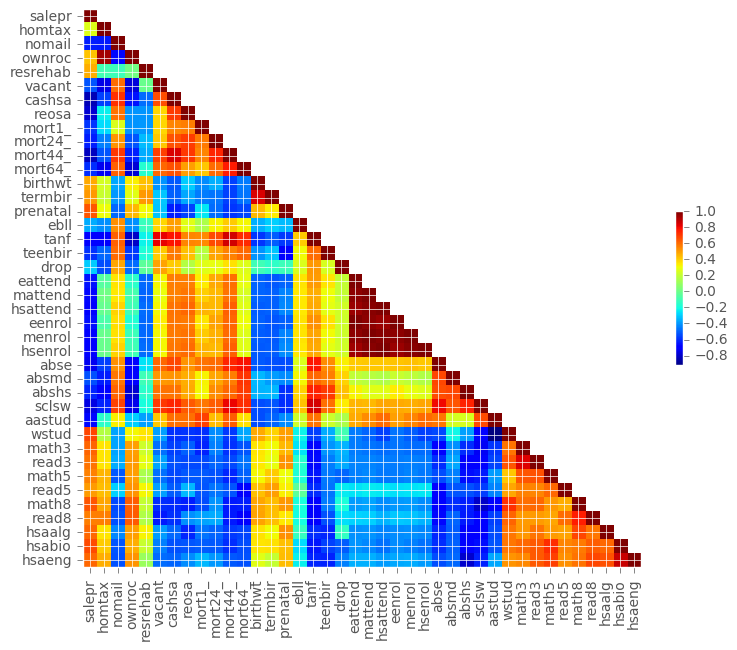

In [84]:
df = correlatedVSAggrDf['2011']
displayCorrelationMatrix(df.corr(method='pearson'))

(array([ 135.,  303.,  301.,  274.,  140.,  131.,  115.,   87.,   37.,   16.]),
 array([ 0.        ,  0.1147353 ,  0.2294706 ,  0.34420591,  0.45894121,
         0.57367651,  0.68841181,  0.80314712,  0.91788242,  1.03261772,
         1.14735302]),
 <a list of 10 Patch objects>)

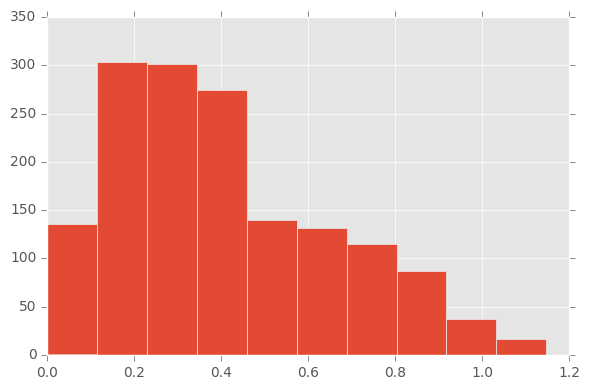

In [85]:
corrPredictors = list(correlatedVSAggrDf['2011'].columns)
corrPredictors.pop(corrPredictors.index('salepr'))
df = correlatedVSAggrDf['2011'][corrPredictors]
df=pd.DataFrame(skl.preprocessing.normalize(df), index=df.index)

neighborhoods = list(df.index)
distances = []
for trailingIndex in range(0,len(neighborhoods)-1):
    for leadingIndex in range(trailingIndex, len(neighborhoods)):
        distances.append(np.linalg.norm(df.loc[neighborhoods[trailingIndex],:]-df.loc[neighborhoods[leadingIndex],:]))
matplotlib.pyplot.hist(distances)

(array([  1.,   1.,   4.,   4.,   1.,   3.,   6.,   4.,  11.,  20.]),
 array([  0. ,   4.2,   8.4,  12.6,  16.8,  21. ,  25.2,  29.4,  33.6,
         37.8,  42. ]),
 <a list of 10 Patch objects>)

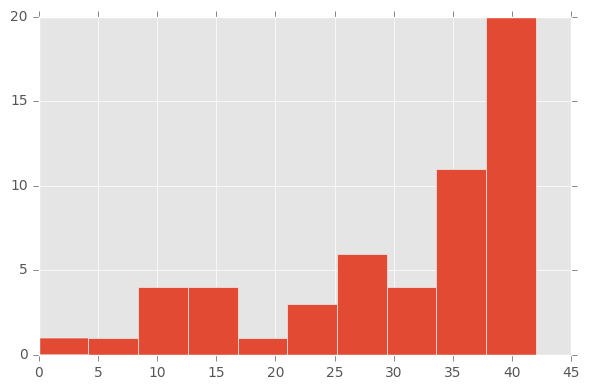

In [86]:
neighborsInEPS = []
for current in neighborhoods:
    count=0
    for neighbor in neighborhoods:
        if neighbor != current:
            dist=np.linalg.norm(df.loc[current,:]-df.loc[neighbor,:])
            if dist<=0.4: count+=1
    neighborsInEPS.append(count)
matplotlib.pyplot.hist(neighborsInEPS)

(array([  9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  46.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

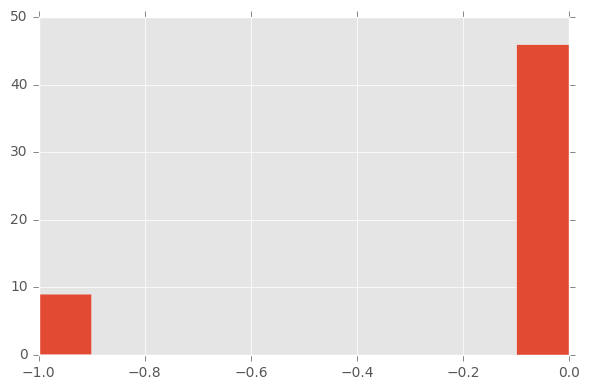

In [91]:
# colInterest = list(correlatedVSAggrDf['2011'].columns)
# colInterest.pop(colInterest.index('salepr'))
# df = correlatedVSAggrDf['2011'][colInterest]
# df=skl.preprocessing.normalize(df)
db = skl.cluster.DBSCAN(eps=0.3, min_samples=20).fit(df)
matplotlib.pyplot.hist(db.labels_)

In [92]:
clustering = pd.DataFrame(db.labels_, index = correlatedVSAggrDf['2011'].index)
clustering.loc[:,'marketTypology'] = vsHousingTypology['MarketTypology_2011']
clustering.columns = ['cluster', 'marketTypology']
clustering.sort_values('cluster', inplace=True)
clustering

,cluster,marketTypology
Inner Harbor/Federal Hill,-1,5
Downtown/Seton Hill,-1,5
North Baltimore/Guilford/Homeland,-1,5
Canton,-1,5
Mount Washington/Coldspring,-1,5
Cross-Country/Cheswolde,-1,5
South Baltimore,-1,5
Fells Point,-1,5
Greater Roland Park/Poplar Hill,-1,5
Northwood,0,5


(array([  9.,  15.,  11.,   2.,   1.,   4.,   2.,   5.,   1.,   5.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

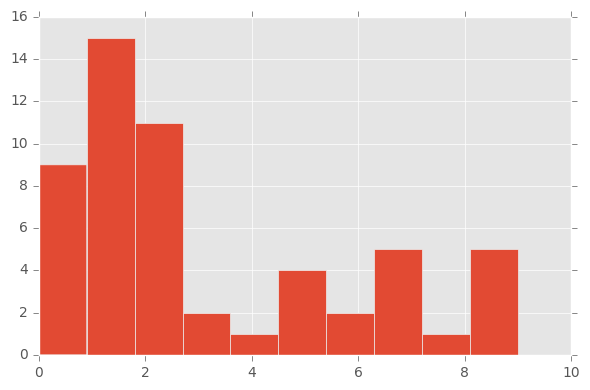

In [48]:
cl=skl.cluster.SpectralClustering(n_clusters=10).fit(df)
matplotlib.pyplot.hist(cl.labels_)

In [49]:
clustering = pd.DataFrame(cl.labels_, index = correlatedVSAggrDf['2011'].index)
clustering.loc[:,'marketTypology'] = vsHousingTypology['MarketTypology_2011']
clustering.columns = ['cluster', 'marketTypology']
clustering.sort_values('cluster', inplace=True)

In [564]:
clustering

,cluster,marketTypology
Westport/Mount Winans/Lakeland,0,1
Morrell Park/Violetville,0,3
Orangeville/East Highlandtown,0,4
Patterson Park North & East,0,5
Claremont/Armistead,0,5
Cherry Hill,0,3
Medfield/Hampden/Woodberry/Remington,0,5
Southeastern,0,4
Brooklyn/Curtis Bay/Hawkins Point,0,2
Chinquapin Park/Belvedere,1,5


In [51]:
spectralClusterings=pd.DataFrame(index = correlatedVSAggrDf[year].index)
for year in ['2011', '2012', '2013', '2014']:
    corrPredictors = list(correlatedVSAggrDf[year].columns)
    corrPredictors.pop(corrPredictors.index('salepr'))
    df = correlatedVSAggrDf[year][corrPredictors]
    df=pd.DataFrame(skl.preprocessing.normalize(df), index=df.index)

    cl=skl.cluster.SpectralClustering(n_clusters=10).fit(df)

    clustering = pd.DataFrame(cl.labels_, index = correlatedVSAggrDf[year].index)
    spectralClusterings.loc[:,'clusters_'+year]=cl.labels_
    spectralClusterings.loc[:,'MarketTypology_'+year] = vsHousingTypology['MarketTypology_'+year]

In [96]:
with open('../out/neighborhoodClusters.csv', 'wb') as outFile:
    spectralClusterings.to_csv(outFile)

In [52]:
spectralClusterings

,clusters_2011,MarketTypology_2011,clusters_2012,MarketTypology_2012,clusters_2013,MarketTypology_2013,clusters_2014,MarketTypology_2014
Allendale/Irvington/S. Hilton,7,1,1,3,0,1,0,1
Beechfield/Ten Hills/West Hills,2,5,5,5,6,5,0,5
Belair-Edison,7,2,1,3,0,2,0,2
Brooklyn/Curtis Bay/Hawkins Point,0,2,8,2,2,2,3,2
Canton,5,5,6,5,7,5,2,5
Cedonia/Frankford,7,4,1,4,0,4,3,4
Cherry Hill,0,3,8,1,4,1,1,1
Chinquapin Park/Belvedere,2,5,0,5,3,5,7,5
Claremont/Armistead,0,5,8,4,4,4,6,4
Clifton-Berea,7,1,1,1,2,1,1,1


In [ ]:
spectralClusterings=pd.DataFrame(index = correlatedVSAggrDf[year].index)
for year in ['2011', '2012', '2013', '2014']: